In [7]:
import neptune as neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker

In [8]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [9]:
def get_neptune_table(tags, negative_tags=None, columns=None):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """
    # Initialize columns if None
    if columns is None:
        columns = []

    # Base columns to always include
    base_columns = ['sys/tags', 'sys/id', 'args/cutoff', 'args/batch_size', 'loss']
    columns.extend(base_columns)

    # Mapping for 'start' and 'end' arguments
    prefix_mapping = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }

    # Components to include in the arguments columns
    components = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']

    # Build columns for each combination of 'start/end' and components
    for position in ['start', 'end']:
        for component in components:
            prefix = prefix_mapping[position]
            column_name = f'args/{prefix}/{component}'
            columns.append(column_name)

    # Initialize the Neptune project
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(
        tag=tags,
        columns=columns
    ).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    runs_table['sys/tags'] = runs_table['sys/tags'].apply(
        lambda x: x.split(',') if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table['sys/tags'].apply(lambda x: neg_tag in x)
            ]

    print(f'Table downloaded\nShape: {runs_table.shape}')
    return runs_table


https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (25, 8)


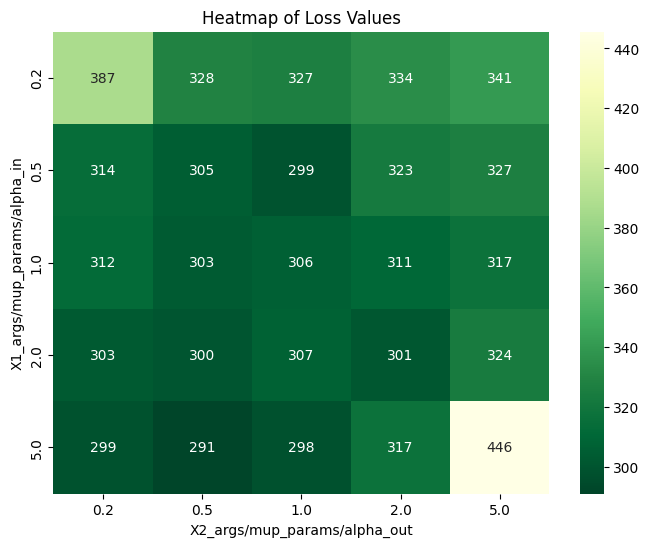

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

LOSS_COL = "loss_interval/100"
X1_COL = "args/mup_params/alpha_in"
X2_COL = "args/mup_params/alpha_out"
runs = get_neptune_table(["alpha_grid", "muP_MoE"], columns=[X1_COL, X2_COL, LOSS_COL])

data = runs[[LOSS_COL, X1_COL, X2_COL]].to_dict("tight")["data"]
data = np.array(data)

loss = data[:, 0]
best_biased = loss.min()
# loss = (loss - loss.min()) / (loss.max() - loss.min())
loss = loss - np.floor(loss)
loss = loss * 1000
data[:, 0] = loss


# Extract x1, x2, and loss
x1_values = sorted(set([x1 for _, x1, _ in data]))
x2_values = sorted(set([x2 for _, _, x2 in data]))
# Create a 2D grid for loss values
loss_grid = np.full((len(x1_values), len(x2_values)), np.nan)

# Fill the grid with loss values
for loss, x1, x2 in data:
    i = x1_values.index(x1)
    j = x2_values.index(x2)
    loss_grid[i, j] = loss

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_grid, annot=True, xticklabels=x2_values, yticklabels=x1_values, cmap='YlGn_r', fmt=".0f")
plt.xlabel(f'X2_{X2_COL}')
plt.ylabel(f'X1_{X1_COL}')
plt.title('Heatmap of Loss Values')
plt.show()